In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm
import sspals
from mc_sspals import initialize, annihilate, convert
from mc_sspals.tools import spectrum
from mc_sspals.laser import Laser, Transition, overlap, frac_excite, t_excite, photoionize
from mc_sspals.plots import bksub

In [3]:
# positrons
num = int(1e6)
sigma_x = 1e-3
sigma_t = 2e-9
# converter
eff = 0.25
T = 400
# Lyman-alpha
lyman_alpha = Transition(wavelength=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
threshold = 0.002
uv = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)
# detector
kappa = 9e-9
dt = 1e-9
limits = [-1.0E-8, 3.5e-8, 7e-7]

In [4]:
di = initialize(num, sigma_t=sigma_t, sigma_x=sigma_x)
df = convert(di, eff=eff, T=T)
df.head()

,status,lifetime,ti,xi,yi,zi,vx,vy,vz
0,e+,0.000000e+00,3.376731e-09,0.001234,0.000725,0.0,NaN,NaN,NaN
1,o-Ps,4.121012e-08,4.714770e-09,-0.001342,0.001660,0.0,-121047.001788,88171.287529,39499.813409
2,e+,0.000000e+00,1.591101e-09,-0.001180,-0.000969,0.0,NaN,NaN,NaN
3,e+,0.000000e+00,1.243650e-09,-0.000438,-0.000282,0.0,NaN,NaN,NaN
4,e+,0.000000e+00,-1.869191e-09,-0.001233,0.000838,0.0,NaN,NaN,NaN


In [5]:
dp = photoionize(df, uv, lyman_alpha, threshold, prob=1.0)
dp.groupby('status').count()

,lifetime,ti,xi,yi,zi,vx,vy,vz
status,,,,,,,,
e+,749555,749555,749555,749555,749555,0,0,0
ion,66653,66653,66653,66653,66653,66653,66653,66653
o-Ps,183792,183792,183792,183792,183792,183792,183792,183792


In [6]:
bk = annihilate(df)
sig = annihilate(dp)

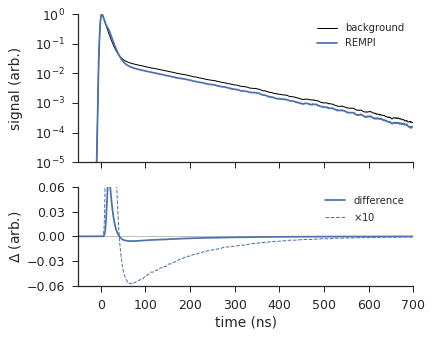

In [7]:
fig, ax = bksub()

# MC
xvals_bk, yvals_bk = spectrum(bk, amp=1.0, dt=dt, kappa=kappa)
ax[0].plot(xvals_bk* 1e9, yvals_bk, c='k', lw=1, label='background')

xvals, yvals = spectrum(sig, amp=1.0, dt=dt, kappa=kappa)
ax[0].plot(xvals* 1e9, yvals, label='REMPI')

ax[1].plot(xvals* 1e9, yvals - yvals_bk, label='difference')
ax[1].plot(xvals* 1e9, 10 * (yvals - yvals_bk), c='C0', ls='--', lw=1, label=r'$\times 10$')

ax[1].set_ylim([-0.06, 0.06])
ax[1].set_yticks([-0.06, -0.03, 0.0, 0.03, 0.06])

ax[0].legend(loc=0, fontsize=10)
ax[1].legend(loc=0, fontsize=10)

sns.despine(ax=ax[0], trim=False)
sns.despine(ax=ax[1], trim=False)

#output
plt.savefig("../images/mc_ion.pdf", bbox_inches='tight', dpi=200)
plt.show()

In [8]:
frac_excite(df, uv, lyman_alpha, threshold, prob=1.0)

0.27862636903268956

In [9]:
fd = sspals.sspals_1d(spectrum(sig, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
fd

0.1749053947038268

In [10]:
fb = sspals.sspals_1d(spectrum(bk, amp=1.0, dt=dt, kappa=kappa)[1], dt, limits=limits)[-1]
fb

0.22667735333294653

In [11]:
sspals.signal(fd, 0, fb, 0)[0]

22.839493168546234